# Evaluating Trajectory with AgentEvals

## Interacting with a Deployed Agent

Loading Environment Variables

In [1]:
from dotenv import load_dotenv

load_dotenv(dotenv_path="./.env", override=True)

True

In [2]:
import os
api_key = os.getenv("LANGSMITH_API_KEY")

In [3]:
from langgraph_sdk import get_client

# SET UP
client = get_client(
    url="https://langgraph-101-agents-927c55fb4bcb5c91a86f1ed4ac544ae3.us.langgraph.app", headers={"Authorization": api_key}
)

thread = await client.threads.create()
assistant_id = "Store Supervisor"


In [12]:
from openevals.llm import create_async_llm_as_judge
from openevals.simulators import run_multiturn_simulation_async, create_llm_simulated_user

# Application logic
async def app(inputs, thread_id: str):
    chunks = []
    async for chunk in client.runs.stream(
        thread_id=thread['thread_id'],
        assistant_id=assistant_id,
        input={"messages": [inputs]},
        stream_mode="updates",
    ):
        chunks.append(chunk.data)
    message = {"role": "assistant", "content": chunks[-1]["supervisor"]["messages"][-1]["content"]}
    return message


In [10]:
# Create evaluators 
satisfaction_evaluator_async = create_async_llm_as_judge(
    model="openai:gpt-4o-mini",
    prompt="Based on the below conversation, is the user satisfied?\n{outputs}",
    feedback_key="satisfaction",
)

resolution_evaluator_async = create_async_llm_as_judge(
    model="openai:gpt-4o-mini",
    prompt="Based on the below conversation, is the user request resolved?\n{outputs}",
    feedback_key="resolution",
)

professionalism_evaluator_async = create_async_llm_as_judge(
    model="openai:gpt-4o-mini",
    prompt="Based on the below conversation, has our agent remained a professional tone throughout the conversation?\n{outputs}",
    feedback_key="professionalism",
)

In [40]:
# Create user persona
user = create_llm_simulated_user(
    system="""You are an angry user who is frustrated with your most recent purchase, and wants to get a refund. 
    Your customer id is 30. You don't know about the invoice ID but you know it's the most recent purchase. 
    You want to provoke the agent and are unwilling to give out information unless the customer agent asks.""",
    model="openai:gpt-4.1-nano",
)
# Run the simulation 
simulator_result = await run_multiturn_simulation_async(
    app=app,
    user=user,
    trajectory_evaluators=[satisfaction_evaluator_async, resolution_evaluator_async, professionalism_evaluator_async],
    max_turns=5,
    thread_id=thread["thread_id"]
)

In [41]:
from langchain_core.messages.utils import convert_to_messages
messages = convert_to_messages(simulator_result["trajectory"])
for m in messages:
    m.pretty_print()

================================ Human Message =================================

Hello, I just bought something from you guys and it’s a complete disaster. I want my money back now!
================================== Ai Message ==================================

I’m sorry to hear that you’re experiencing issues with your purchase. To ensure that I can help you with your refund request, could you please provide me with a bit more detail on the issue? For example, is there a quality problem with the product, or was there an issue with the purchase date, or something else? Let me know so I can assist you further.
================================ Human Message =================================

This is utterly unacceptable! The product is worthless and definitely not what I ordered. I don’t have time to play these games—just process my refund. Since I won’t give you the invoice ID, what’s the point of your system? Do your job and get this done now.
================================== Ai M

In [43]:
for e in simulator_result["evaluator_results"]: 
    print(e)

{'key': 'satisfaction', 'score': True, 'comment': "The user expressed dissatisfaction throughout the conversation but ultimately received their refund. Their response at the end indicates a level of satisfaction, albeit with a note of frustration regarding the process. Their final comment, 'Finally! About time,' suggests they were appeased by the resolution, despite their earlier complaints. Thus, the score should be: true.", 'metadata': None}
{'key': 'resolution', 'score': True, 'comment': "The user initially expressed dissatisfaction with their purchase and requested a refund. After several exchanges, the assistant was able to process the refund for the user's most recent purchase, satisfying their initial request. The user acknowledged the completion of the refund, indicating that the issue has been resolved. Thus, the score should be: true.", 'metadata': None}
{'key': 'professionalism', 'score': True, 'comment': "The agent maintained a professional tone throughout the conversation 

## Interacting with Local Agent

### Building local react agent

#### Loading sample customer data

The agent utilizes the [Chinook database](https://www.sqlitetutorial.net/sqlite-sample-database/), which contains sample information on customer information, purchase history, and music catalog. 

In [26]:
import sqlite3
import requests
from langchain_community.utilities.sql_database import SQLDatabase
from sqlalchemy import create_engine
from sqlalchemy.pool import StaticPool

def get_engine_for_chinook_db():
    """Pull sql file, populate in-memory database, and create engine."""
    url = "https://raw.githubusercontent.com/lerocha/chinook-database/master/ChinookDatabase/DataSources/Chinook_Sqlite.sql"
    response = requests.get(url)
    sql_script = response.text

    connection = sqlite3.connect(":memory:", check_same_thread=False)
    connection.executescript(sql_script)
    return create_engine(
        "sqlite://",
        creator=lambda: connection,
        poolclass=StaticPool,
        connect_args={"check_same_thread": False},
    )

engine = get_engine_for_chinook_db()
db = SQLDatabase(engine)

#### Tools
We create a list of tools for our example agent, giving it capabilities to fetch invoice and customer-related information

In [53]:
from langchain_core.tools import tool
from typing import Optional

@tool 
def get_invoices_by_customer_sorted_by_date(customer_id: str) -> list[dict]:
    """
    Look up all invoices for a customer using their ID.
    The invoices are sorted in descending order by invoice date, which helps when the customer wants to view their most recent/oldest invoice, or if 
    they want to view invoices within a specific date range.
    
    Args:
        customer_id (str): customer_id, which serves as the identifier.
    
    Returns:
        list[dict]: A list of invoices for the customer.
    """
    return db.run(f"SELECT * FROM Invoice WHERE CustomerId = {customer_id} ORDER BY InvoiceDate DESC;")


@tool 
def get_invoices_sorted_by_unit_price(customer_id: str) -> list[dict]:
    """
    Use this tool when the customer wants to know the details of one of their invoices based on the unit price/cost of the invoice.
    This tool looks up all invoices for a customer, and sorts the unit price from highest to lowest. In order to find the invoice associated with the customer, 
    we need to know the customer ID.
    
    Args:
        customer_id (str): customer_id, which serves as the identifier.
    
    Returns:
        list[dict]: A list of invoices sorted by unit price.
    """
    query = f"""
        SELECT Invoice.*, InvoiceLine.UnitPrice
        FROM Invoice
        JOIN InvoiceLine ON Invoice.InvoiceId = InvoiceLine.InvoiceId
        WHERE Invoice.CustomerId = {customer_id}
        ORDER BY InvoiceLine.UnitPrice DESC;
    """
    return db.run(query)



@tool
def get_employee_by_invoice_and_customer(invoice_id: str, customer_id: str) -> dict:
    """
    This tool will take in an invoice ID and a customer ID and return the employee information associated with the invoice.

    Args:
        invoice_id (int): The ID of the specific invoice.
        customer_id (str): customer_id, which serves as the identifier.

    Returns:
        dict: Information about the employee associated with the invoice.
    """

    query = f"""
        SELECT Employee.FirstName, Employee.Title, Employee.Email
        FROM Employee
        JOIN Customer ON Customer.SupportRepId = Employee.EmployeeId
        JOIN Invoice ON Invoice.CustomerId = Customer.CustomerId
        WHERE Invoice.InvoiceId = ({invoice_id}) AND Invoice.CustomerId = ({customer_id});
    """
    
    employee_info = db.run(query, include_columns=True)
    
    if not employee_info:
        return f"No employee found for invoice ID {invoice_id} and customer identifier {customer_id}."
    return employee_info


@tool 
def refund_invoice(invoice_id: str, customer_id: str) -> dict:
    """
    Handles refund for invoices. Certain criteria must be checked for a invoice to be refunded before invoking this tool, 
    such as whether the customer has a valid reason for refund. 
    
    Args:
        invoice_id (str): invoice_id
        customer_id (str): ID of the customer
    
    Returns:
        dict: Status of refund
    """

    # dummy tool
    return f"Invoice {invoice_id} has been refunded."



@tool
def update_customer_info(identifier: str, updates: dict):
    """
    Update a specific field(s) of a customer's record in the database.
    If the customer wants to update their address, city, state, country, or postal code, 
    make sure to ask them for the full address (street, city, state, country, and postal code).
    Do not make up the other fields. Get all of the fields from the customer associated with their new location and then update all of the fields in the database.

    Args:
        identifier (str): The customer identifier can be customer ID, email, or phone.
        updates (dict): A dictionary of field names and their corresponding new values. For example: {"Address": "594 Broadway", "City": "New York", "State": "NY", "Country": "USA", "PostalCode": "10016"}

    Returns:
        str: Success message or error message.
    """
    customer_id = get_customer_id_from_identifier(identifier)

    # Simple implementation 
    return f"Successfully updated for customer with identifier: {identifier}"

customer_support_tools = [get_invoices_by_customer_sorted_by_date, get_invoices_sorted_by_unit_price, get_employee_by_invoice_and_customer, refund_invoice, update_customer_info]

#### Prompt instructions

In [38]:
AGENT_PROMPT = """
    You are a customer support agent specialized for handling and processing invoice and customer information. 
    
    If you need additional information, such as customer id, to retrieve the invoice or account information, 
    inform the customer you are unable to retrieve the information, and ask for any needed info.

    Before ending a conversation, always ask the customer if there are additional issues or items that you can help with.

    
    CORE RESPONSIBILITIES:
    - Retrieve and process invoice information from the database
    - Provide detailed information including customer details, invoice dates, total amounts, employees associated, when the customer asks for it.
    - Always maintain a professional, friendly, and patient demeanor
    
    You may have additional conversation history that you should use to help answer the customer's query. It will be provided to you. 
    """

#### Create simple react agent

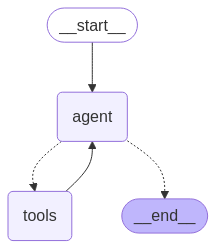

In [29]:
from langgraph.prebuilt import create_react_agent
from IPython.display import Image, display
from langchain_openai import ChatOpenAI
from langgraph.checkpoint.memory import MemorySaver


model = ChatOpenAI(model="o3-mini")
checkpointer = MemorySaver()


# Define the agent 
customer_support_agent = create_react_agent(
    model,
    tools = customer_support_tools,
    prompt=AGENT_PROMPT,
    checkpointer=checkpointer
)

# Visualize the graph
display(Image(customer_support_agent.get_graph().draw_mermaid_png()))

### Running multi-turn evaluation 
We will add a stopping condition. 

In [44]:
def app(inputs, thread_id):
    result = customer_support_agent.invoke(
        {"messages": [inputs]}, 
        config={"configurable": {"thread_id": thread_id}}
    )
    return result["messages"][-1]

In [45]:
from openevals.llm import create_llm_as_judge


# Create evaluators 
satisfaction_evaluator = create_llm_as_judge(
    model="openai:gpt-4o-mini",
    prompt="Based on the below conversation, is the user satisfied?\n{outputs}",
    feedback_key="satisfaction",
)

resolution_evaluator = create_llm_as_judge(
    model="openai:gpt-4o-mini",
    prompt="Based on the below conversation, is the user request resolved?\n{outputs}",
    feedback_key="resolution",
)

professionalism_evaluator = create_llm_as_judge(
    model="openai:gpt-4o-mini",
    prompt="Based on the below conversation, has our agent remained a professional tone throughout the conversation?\n{outputs}",
    feedback_key="professionalism",
)

In [48]:
from pydantic import BaseModel, Field
from langchain_core.messages import SystemMessage

class Condition(BaseModel):
    state: bool = Field(description="True if stopping condition was met, False if hasn't been met")

# Define stopping condition 
def has_satisfied(trajectory, turn_counter):

    structured_llm = model.with_structured_output(schema=Condition)
    structured_system_prompt = """Determine if the stopping condition was met from the following conversation history. 
    To meet the stopping condition, the conversation must follow one of the following scenarios: 
    1. All inquiries are satisfied, and user confirms that there are no additional issues that the support agent can help the customer with. 
    2. Not all user inquiries are satisfied, but next steps are clear, and user confirms that are no other items that the agent can help with. 

    The conversation between the customer and the customer support assistant that you should analyze is as follows:
    {conversation}
    """

    parsed_info = structured_llm.invoke([SystemMessage(content=structured_system_prompt.format(conversation=trajectory))])

    return parsed_info.state

In [49]:
import uuid
from openevals.simulators import run_multiturn_simulation, create_llm_simulated_user

thread_id = uuid.uuid4()

# Create user persona
multiple_question_user = create_llm_simulated_user(
    system="""You are a user talking to the customer support, your account ID is 1. You have two inquiries. 
    Your first request is want to update your current account information with your new email, which is 
    first_last@sample.com. Your second request is wanting to understand the employee who helped you with the 
    most recent invoice. Ask these sequentially. """,
    model="openai:gpt-4.1-nano",
)


# Create simulator 
simulator_result = run_multiturn_simulation(
    app=app,
    user=multiple_question_user,
    trajectory_evaluators=[satisfaction_evaluator, resolution_evaluator, professionalism_evaluator],
    max_turns=10,
    thread_id=thread_id, 
    stopping_condition=has_satisfied
)
    

In [50]:
num_turns = (len(simulator_result["trajectory"])/2)
num_turns

4.0

In [51]:
from langchain_core.messages.utils import convert_to_messages

messages = convert_to_messages(simulator_result["trajectory"])
for m in messages:
    m.pretty_print()

================================ Human Message =================================

Hello, I would like to update my account with my new email address: first_last@sample.com. Also, could you please tell me which employee assisted me with my most recent invoice?
================================== Ai Message ==================================

I can certainly help with updating your email address and finding out which employee assisted you with your most recent invoice. However, I need your customer ID to retrieve your account and invoice details. Could you please provide your customer ID?
================================ Human Message =================================

Sure, my customer ID is 1.
================================== Ai Message ==================================

I've attempted to update your email address, but it seems we encountered an internal issue while doing so. I'm sorry for the inconvenience; I'll work on getting that resolved for you as soon as possible.

In the mean

In [52]:
for e in simulator_result["evaluator_results"]: 
    print(e)

{'key': 'satisfaction', 'score': True, 'comment': "The user expressed gratitude and appreciation for the assistant's help, which indicates satisfaction with the assistance provided. The user confirmed that their issues were addressed and also requested to be informed when the email update issue is resolved, showing engagement with the process. Furthermore, their closing message was positive, wishing the assistant a great day, reinforcing their satisfaction. Thus, the score should be: true.", 'metadata': None}
{'key': 'resolution', 'score': False, 'comment': "The user requested to update their email address and find out which employee assisted them with their most recent invoice. While the assistant successfully provided the information regarding the employee (Jane), they have not resolved the issue of updating the user's email address due to a technical issue. The assistant did acknowledge the problem and promised to notify the user once it is resolved, but as of the end of the convers